In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn import preprocessing
from sklearn.cluster import KMeans

#load dataset and display first 5 rows
df = pd.read_csv("UsArrests.csv")
df.head()
#here

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.20,236,58,21.20
1,Alaska,10.00,263,48,44.50
2,Arizona,8.10,294,80,31.00
3,Arkansas,8.80,190,50,19.50
4,California,9.00,276,91,40.60


In [7]:
#generate summary statistics, reference: L3T13_example_plots.ipynb

#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


In [3]:
#find missing data if any

# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


Fortunately, there is no missing data, so we do not need to worry about this in cleaning the data. Next we will begin visualizing the data to better understand the features we are working with. I will do this by creating histograms of each feature.

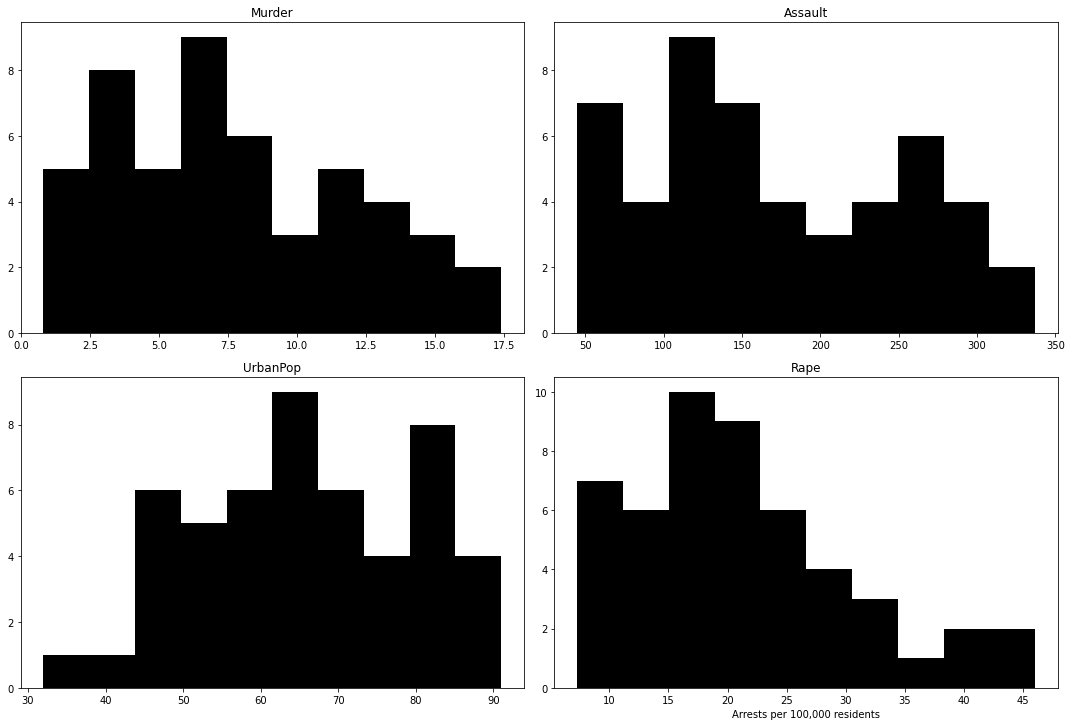

In [5]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.xlabel('Arrests per 100,000 residents')
plt.show()

Overall, the Murder and Rape distributions tend to be right skewed, while the UrbanPop is slightly left skewed. Assault is the closest of all to a normal distribution.

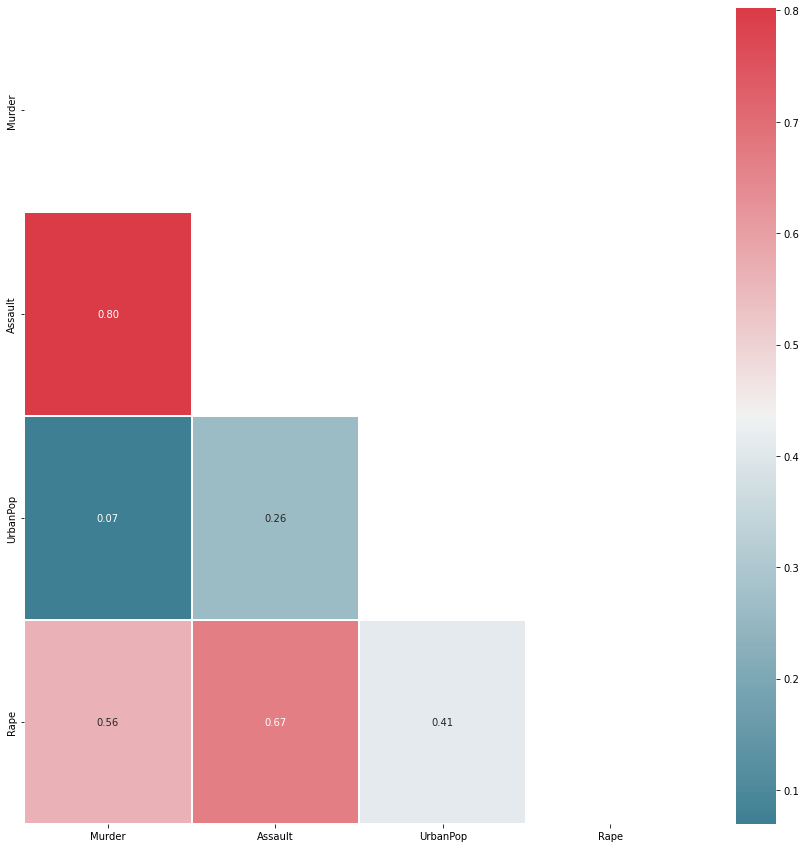

In [8]:
#create plot to show correlations between all features in the UsArrests dataset. For reference to do this, see PCA.ipynb 
colormap = sns.diverging_palette(220, 10, as_cmap=True)

def corr_heatmap(df):
  # get correlations
  corrs = df.corr()

  # pick appropriate palette for heatmap

  # Plot figsize
  fig, ax = plt.subplots(figsize=(15, 15))

  # to mask mirrored side of heatmap
  dropSelf = np.zeros_like(corrs)
  dropSelf[np.triu_indices_from(dropSelf)] = True

  # Generate heat map
  ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

  plt.show()

corr_heatmap(df)

Here we can see that Assault is highly correlated with Murder with a value of 0.8, as well as Assault is moderately correlated with Rape with a value of 0.67. This presents an issue with multicollinearity, to rectify this issue, I will utilize PCA to remove the redundancies.

In [46]:
# drop rows with missing values
df = df.dropna()

# select columns and rows
x = df.iloc[:, [1,2,3,4]].values.reshape(-1, 4)

#scale data to be between 0-1
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)

# generate number of components needed for variance to be 99%
pca = PCA(n_components=0.99)

# obtain components
principal_components = pca.fit_transform(x).reshape(-1, 4)

# transform the components into a pandas data frame
pca_df = pd.DataFrame(principal_components)

# This is to include the id  as the rownames in the PC's
pca_df.head()

,0,1,2,3
0,0.293,0.273,-0.099,0.048
1,0.497,0.225,0.502,-0.133
2,0.460,-0.201,0.003,-0.223
3,-0.006,0.276,0.029,-0.051
4,0.612,-0.410,0.143,-0.093


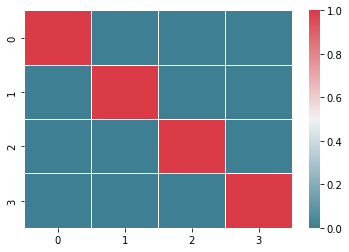

In [40]:
#create plot to show correlations between all features of pca dataframe. For reference to do this, see PCA.ipynb 
ax = sns.heatmap(pca_df.corr(), cmap=colormap,linewidth=1)
plt.show()

After completing PCA, we can now see that the correlations of the components have all dropped to 0, meaning we have rectified the multicollinearity issue in the original dataset. 

In [47]:
# Feature importance, reference: L3T13_example_plots.ipynb
labels =df.corr()


pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )
pc3 = abs( pca.components_[2] )
pc4 = abs( pca.components_[3] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df["PC3 Importance"] = pc3
feat_df["PC4 Importance"] = pc4
feat_df

,Features,PC1 Importance,PC2 Importance,PC3 Importance,PC4 Importance
0,Murder,0.548,0.388,0.268,0.691
1,Assault,0.646,0.152,0.265,0.700
2,UrbanPop,0.230,0.880,0.381,0.165
3,Rape,0.480,0.226,0.844,0.074


Primarily looking at the first component PC1, we see it is relatively evenly distributed with only UrbanPop not contributing as much as the other 3, but still contributing nonetheless. In PC2 through PC4, we see one or two features that do the majority of the contributing, but the other features do still contribute, just not as evenly as PC1. Overall, as PC1 is good and the others are not utilizing features of no contribution, I will continue with this PCA dataframe for the remainder of the analysis.
We can begin our applications of two clustering techniques: Kmeans and Hierarchical clustering using agglomerative clustering.

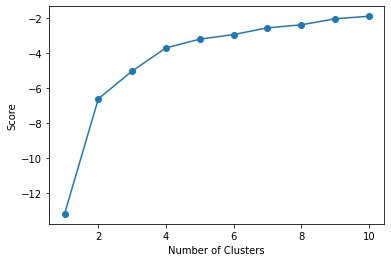

In [48]:
#fit kmeans model using pca_df, look at how score is affected by number of clusters. reference: kmeans.ipynb

def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(x)    
    return kmeans.score(x)

def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.show()

elbow_Kmeans(pca_df)

Here we can see that as the number of clusters increases, the score improves until leveling off at -2. For clustering scores, the larger the negative number the worse the model, so I will fit a model using 8 clusters as there is only maginal improvement past this.

In [68]:
#fit model
kmeans = KMeans(n_clusters=8, random_state=123)
kmeans.fit(pca_df)  

KMeans(random_state=123)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


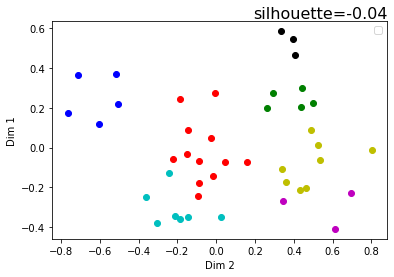

In [78]:
#graph cluster plot reference: L3T13_example_plots.ipynb
# We extract the first two components
x = pca_df[0].values.reshape(-1, 1)
y = pca_df[1].values.reshape(-1, 1)

# Fit k-means
k=8
#kmeans = KMeans(n_clusters=k, init='k-means++', random_state=123)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgycmkw'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

score = round(silhouette_score(x, kmeans.labels_, metric='euclidean'),2)
plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

With a silhouette score of -0.04, the value is very close to 0. This tells us that there is overlap in the clusters, which may lead to some points being placed in the wrong category. As we can see from the graph, cyan and red, as well as purple and yellow are very close to each other. Take notice to the units of measurements as well, which shows exatly how close these clusters are to each other. With this in mind, I have relatively low confidence in this generated model. I will next be creating a agglomerative cluster model which will hopefully gives better results.

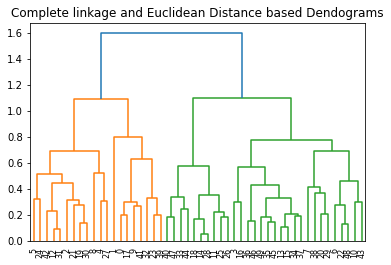

In [71]:
#dendrogram for complete linkage and euclidean distance
clusters = linkage(pca_df, method = 'complete', metric = 'euclidean')
plt.title("Complete linkage and Euclidean Distance based Dendograms")  
dend = dendrogram(clusters) 

Looking at the dendogram, I have created a graph using a complete linkage method and the euclidean distance formula. From this we can see that the dendogram splits into 2 main n clusters, so I will use 2 clusters in the agglomerative model.

In [72]:
#moving forward, I will create a agglomerative clusering model with equlidean distance and linkage method complete. This has 2 clusters
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
cluster.fit(pca_df)

AgglomerativeClustering(linkage='complete')

Text(0.5, 1.0, 'Scatterplot of first 2 components from pca_df')

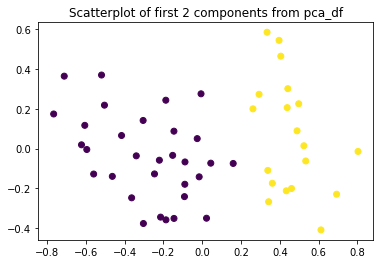

In [77]:
cluster.fit_predict(x)
plt.scatter(pca_df[0], pca_df[1], c=cluster.labels_)
plt.title('Scatterplot of first 2 components from pca_df')

In [76]:
#obtain silhouette score
score = round(silhouette_score(pca_df, cluster.labels_),2)
print('Silhouette Score: ' + str(score))

Silhouette Score: 0.42


Looking at the scatterplot and silhouette score, I already have greater confidence in this model. The grarph shows more space between the clusters, so there is less liklihood that a points will be confused between clusters. Furthermore, with a silhouette score of 0.42, there is already greater confidence in its performance. The kmeans moodel had a silhouette score of -0.04, which showed the major weakness of the model being the overlapping clusters. This agglomerative clustering model fixes that issue, and it is apparenent that the boundaries of the clusters are much better seperated with the score of 0.42.